# Gaussian Processes

Build up the theory behind gaussian processes

## 1. Implementation from scratch

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [8]:
class GaussianProcess():
    def __init__(self, kernel, noise_level):
        self.kernel = kernel
        self.noise_level = noise_level
        
        self.X = None
        self.y = None

        self.K = None
        self.L = None
        self.alpha = None

    def compute_covariance_matrix(self, x1, x2):
        K = np.zeros((len(x1), len(x2)))
        for i in range(len(x1)):
            for j in range(len(x2)):
                K[i, j] = self.kernel(x1[i], x2[j])
        return K + self.noise_level * np.eye(len(x1))

    def fit(self, x_train, y_train):
        self.X = x_train
        self.y = y_train
        
        self.K = self.kernel(self.X, self.X) + self.noise_level * np.eye(len(self.X))  # K(X, X) + noise^2 * I
        self.L = np.linalg.cholesky(self.K)
        self.alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.y))

    def predict(self, X_test):
        # Algorithm 2.1
        # Covariance between training points and test points
        K_star = self.kernel(self.X, X_test)  # K(X, X*)

        # Predictive mean
        mean_star = K_star.T @ self.alpha

        # Solve for v: L @ v = k_star
        v = np.linalg.solve(self.L, K_star)

        # Predictive variance
        K_star_star = self.kernel(X_test, X_test)  # K(X*, X*)
        var_star = K_star_star - v.T @ v

        # Log marginal likelihood
        log_marginal_likelihood = -0.5 * self.y.T @ self.alpha - np.sum(np.log(np.diag(self.L))) - (len(self.y) / 2) * np.log(2 * np.pi)

        return mean_star, var_star, log_marginal_likelihood

    def sample_functions(self, mean, K, n_samples):
        y = []
        for i in range(n_samples):
            y.append(np.random.multivariate_normal(mean, K))
        return np.array(y)
        
    # Visualization functions
    def plot_covariance_matrix(self, K):
        plt.figure(figsize=(3, 2))
        plt.imshow(K, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title(f'Covariance Matrix of {self.kernel.__name__}')
        plt.show()

In [9]:
# Kernel functions
def rbf_kernel(x1, x2, length_scale=1.0, variance=0.1):
    return variance**2 * np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * length_scale**2))

def rbf_kernel_mult(X1, X2, length_scale=0.4, variance=2.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

def linear_kernel_mult(X1, X2, slope=1.0, intercept=0.0):
    return slope * np.dot(X1, X2.T) + intercept

### Untrained GP

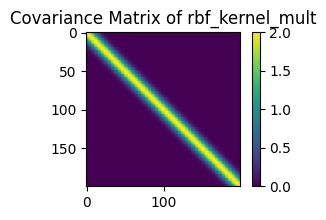

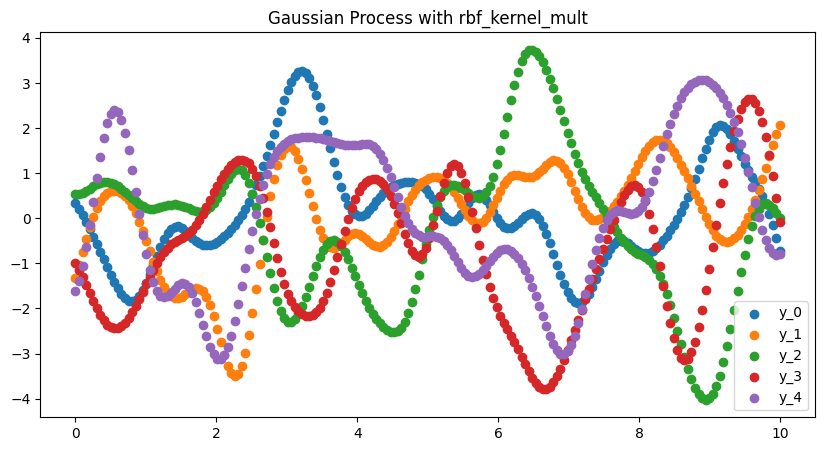

In [10]:
X = np.linspace(0, 10, 200)

# gp = GaussianProcess(kernel=rbf_kernel, noise_level=0)
gp = GaussianProcess(kernel=rbf_kernel_mult, noise_level=0)
# gp = GaussianProcess(kernel=linear_kernel_mult, noise_level=0)

# gp.K = gp.compute_covariance_matrix(X, X)
gp.K = gp.kernel(X.reshape(-1, 1), X.reshape(-1, 1))

y = gp.sample_functions(np.zeros(len(X)), gp.K, 5)

gp.plot_covariance_matrix(gp.K)

plt.figure(figsize=(10, 5))
for i, y_i in enumerate(y):
    plt.scatter(X, y_i, label=f"y_{i}")
plt.legend()
plt.title(f'Gaussian Process with {gp.kernel.__name__}')
plt.show()

### Trained GP

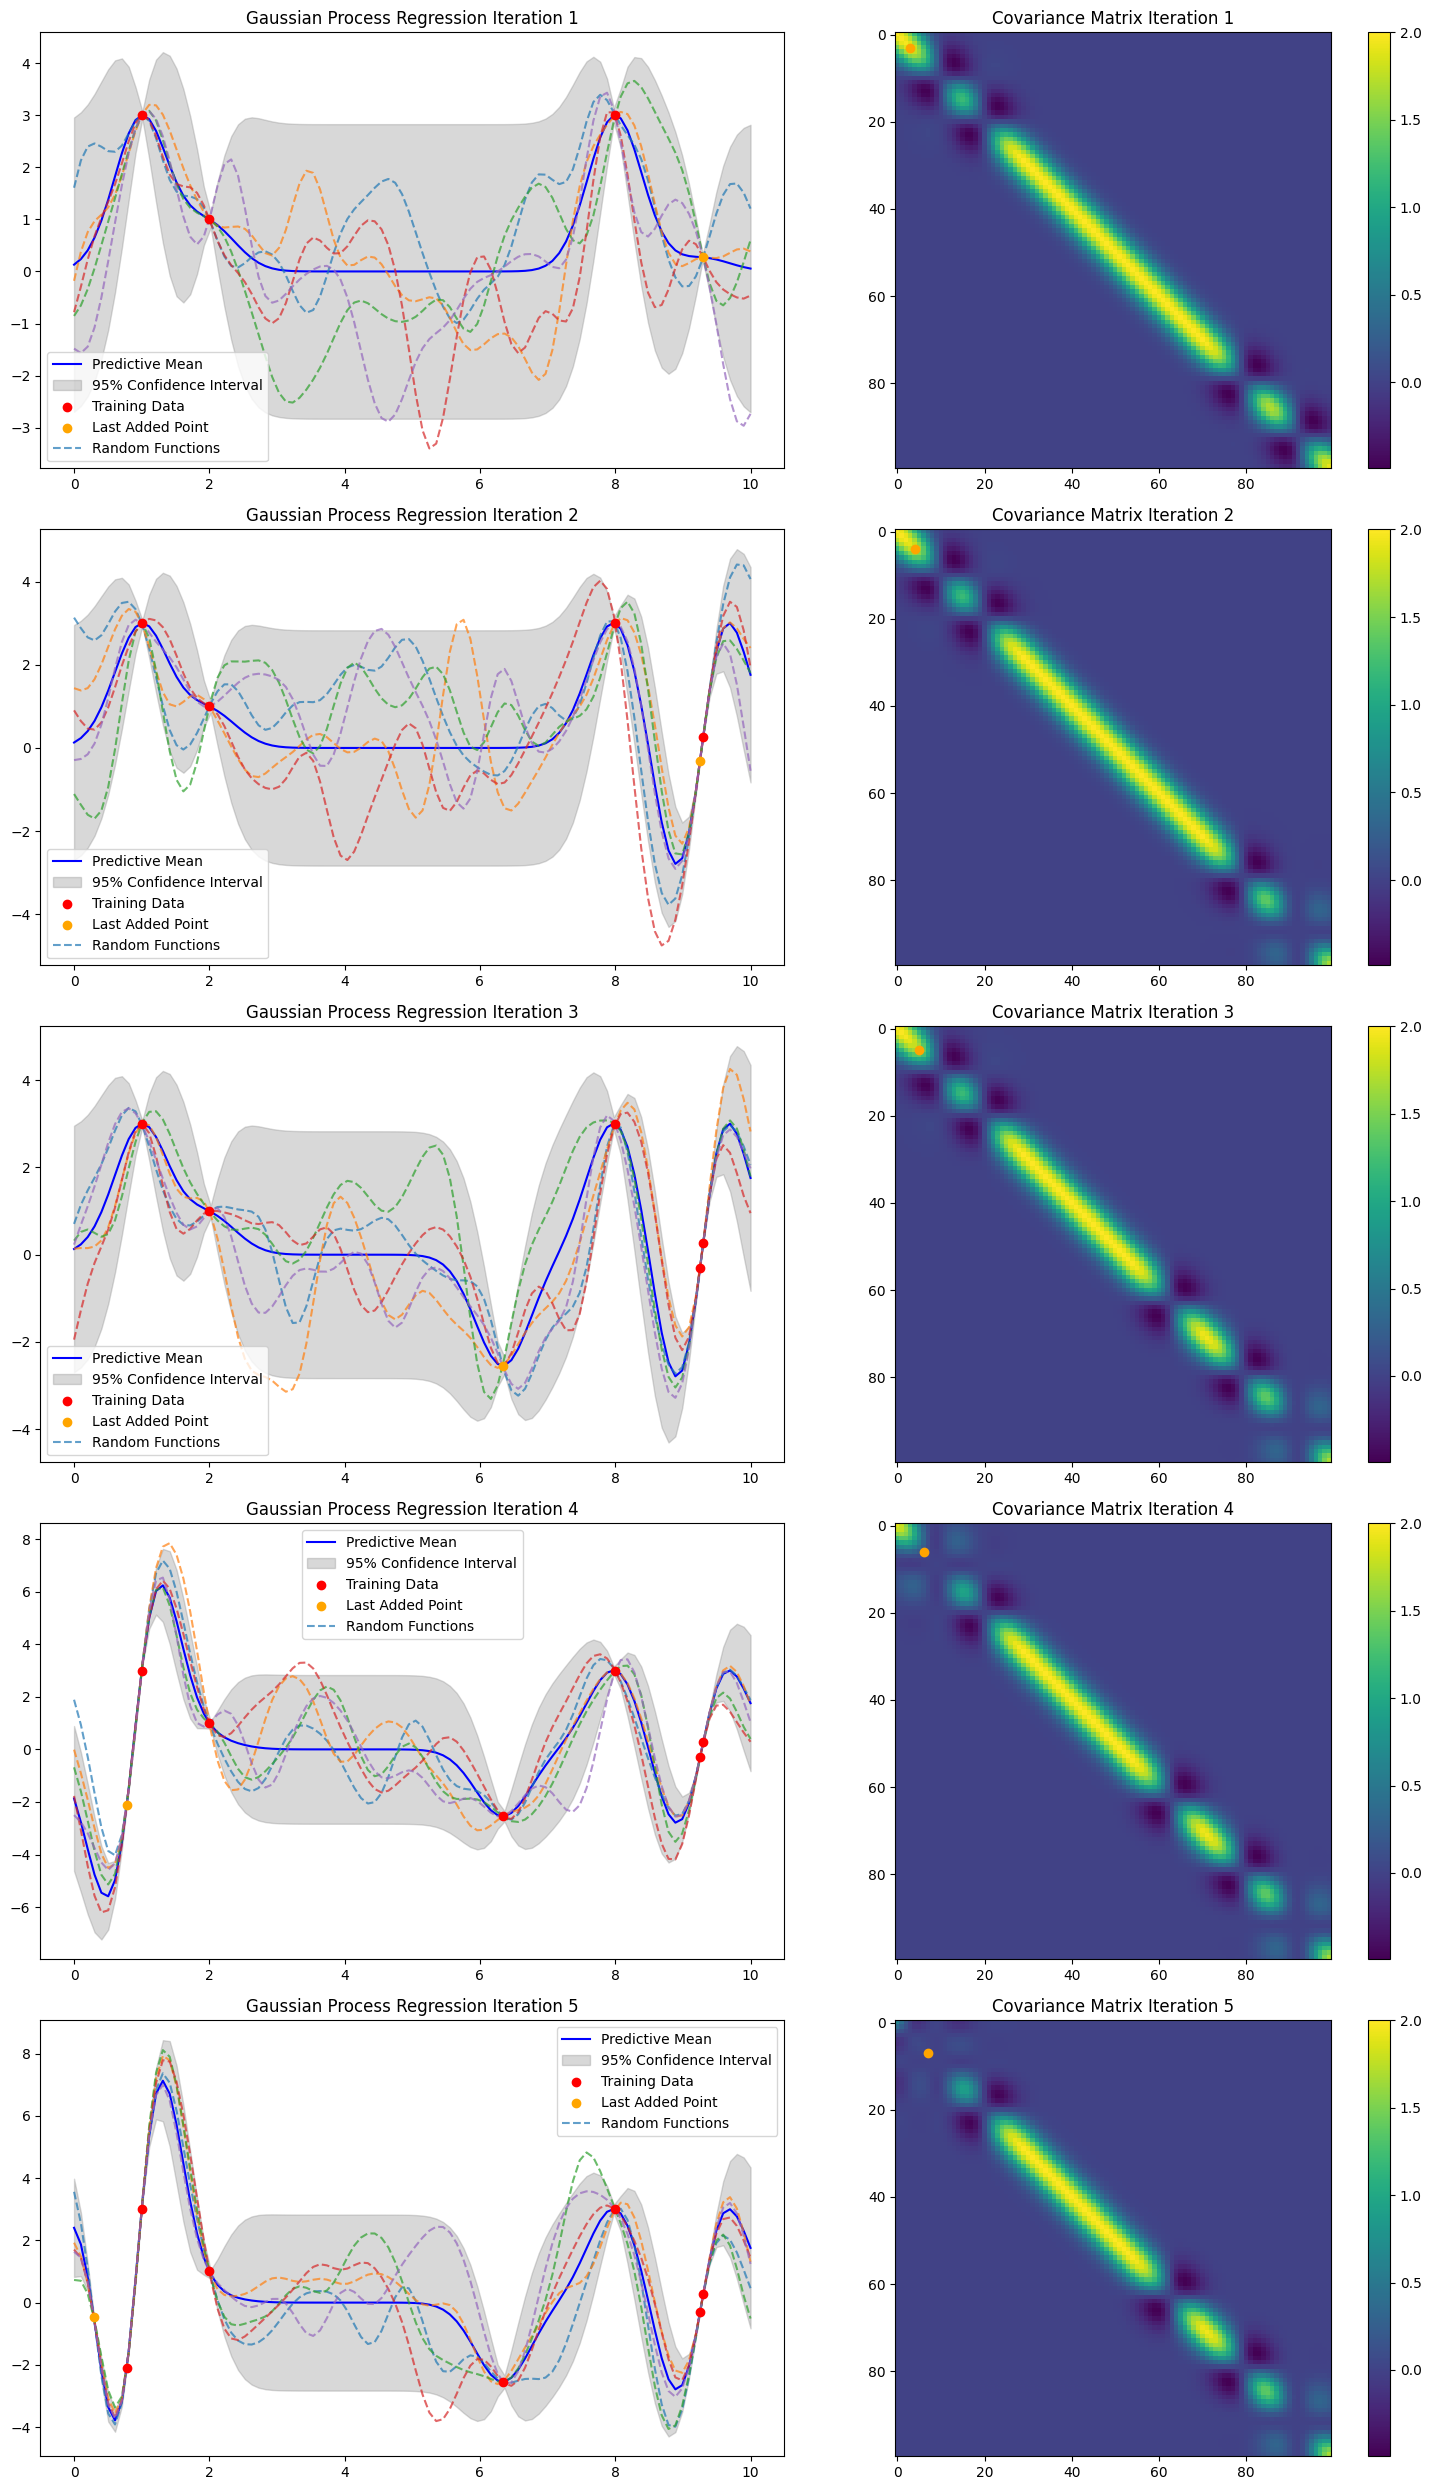

In [11]:
# Training data
X_train = np.array([[1.0], [2.0], [8.0]])
y_train = np.array([3.0, 1.0, 3.0])

# Test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
X_test2 = np.linspace(0, 10, 104).reshape(-1, 1)

# Gaussian Process Regression model
gp = GaussianProcess(kernel=rbf_kernel_mult, noise_level=0)

fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # Fixed to 5 iterations

for idx in range(5):
    # Update training data with new random points
    new_x_value = np.random.uniform(0, 10)
    new_y_value = np.random.uniform(-3, 3)

    X_train = np.append(X_train, [[new_x_value]], axis=0)
    y_train = np.append(y_train, new_y_value)

    gp.fit(X_train, y_train)

    # Predictions
    mean_star, var_star, log_marginal_likelihood = gp.predict(X_test)

    # Randomly drawn functions
    random_functions = gp.sample_functions(mean_star, var_star, 5)

    # Left column: Gaussian Process regression
    axes[idx, 0].plot(X_test.ravel(), mean_star, '-', color='blue', label='Predictive Mean')
    axes[idx, 0].fill_between(X_test.ravel(), 
                               mean_star - 2 * np.sqrt(np.diag(var_star)), 
                               mean_star + 2 * np.sqrt(np.diag(var_star)), 
                               color='grey', alpha=0.3, label='95% Confidence Interval')
    axes[idx, 0].scatter(X_train[:-1], y_train[:-1], color='red', label='Training Data', zorder=5)
    axes[idx, 0].scatter(X_train[-1], y_train[-1], color='orange', label='Last Added Point', zorder=6)
    for i, func in enumerate(random_functions):
        if i == 0:
            axes[idx, 0].plot(X_test.ravel(), func, linestyle='--', alpha=0.7, label='Random Functions')
        else:
            axes[idx, 0].plot(X_test.ravel(), func, linestyle='--', alpha=0.7)
    axes[idx, 0].set_title(f'Gaussian Process Regression Iteration {idx+1}')
    axes[idx, 0].legend()

    # Right column: Covariance matrix
    im = axes[idx, 1].imshow(var_star, cmap='viridis', interpolation='nearest')
    last_point_index = len(X_train) - 1
    axes[idx, 1].scatter(last_point_index, last_point_index, color='orange', label='Last Point', zorder=6)
    axes[idx, 1].set_title(f'Covariance Matrix Iteration {idx+1}')
    fig.colorbar(im, ax=axes[idx, 1])

plt.tight_layout()
plt.show()

## 2. GPyTorch

In [12]:
import torch
import gpytorch

## Training data
as in example

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$

with 100 training examples, and testing on 51 test examples.

In [18]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 80)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.08)

In [19]:
class ExactGPModel(gpytorch.models.ExactGP):  # Follows the same logic as PyTorch models
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):  # 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Training the model

- Core training loops needs to be specified by the user
- Use of stadard PyTorch optimizers

Standard components of PyTorch training loop:
1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call the backward on the loss to fill in the gradients
4. Take a step on the optimizer

In [15]:
# Set model and likelihood to training mode
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()

    print(f"Iteration: {i+1:02}", 
          f" Loss: {loss.item():.2f}",
          f" Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.2f}",
          f" Noise:  {model.likelihood.noise.item():.2f}")
    
    optimizer.step()

Iteration: 01  Loss: 0.97  Lengthscale: 0.69  Noise:  0.69
Iteration: 02  Loss: 0.94  Lengthscale: 0.64  Noise:  0.64
Iteration: 03  Loss: 0.91  Lengthscale: 0.60  Noise:  0.60
Iteration: 04  Loss: 0.88  Lengthscale: 0.55  Noise:  0.55
Iteration: 05  Loss: 0.85  Lengthscale: 0.51  Noise:  0.51
Iteration: 06  Loss: 0.80  Lengthscale: 0.48  Noise:  0.47
Iteration: 07  Loss: 0.76  Lengthscale: 0.44  Noise:  0.44
Iteration: 08  Loss: 0.72  Lengthscale: 0.40  Noise:  0.40
Iteration: 09  Loss: 0.67  Lengthscale: 0.37  Noise:  0.37
Iteration: 10  Loss: 0.63  Lengthscale: 0.34  Noise:  0.34
Iteration: 11  Loss: 0.60  Lengthscale: 0.31  Noise:  0.31
Iteration: 12  Loss: 0.57  Lengthscale: 0.29  Noise:  0.28
Iteration: 13  Loss: 0.54  Lengthscale: 0.27  Noise:  0.26
Iteration: 14  Loss: 0.52  Lengthscale: 0.25  Noise:  0.24
Iteration: 15  Loss: 0.49  Lengthscale: 0.24  Noise:  0.22
Iteration: 16  Loss: 0.47  Lengthscale: 0.23  Noise:  0.20
Iteration: 17  Loss: 0.45  Lengthscale: 0.22  Noise:  0.

In [16]:
# Set model and likelihood to eval mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 51)
observed_pred = likelihood(model(test_x))
gauss_pred = model(test_x)

## Plot model fit

- Posterior distribution over the function (p(f* | x*, X, y)): This is the distribution over the underlying function values at the test point. It represents the GP model’s belief about where the function lies, without considering observation noise.
    `model(test_x)`
  
- Posterior predictive distribution (p(y* | x*, X, y)): This is the distribution over the actual observed output at the test point. It includes both the uncertainty from the GP model and the noise in the observations.
    `likelihood(model(test_x))`

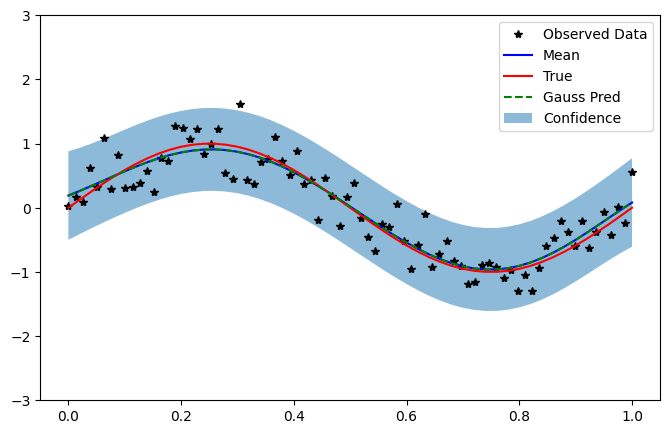

In [17]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    lower, upper = observed_pred.confidence_region()

    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Observed Data')

    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b', label='Mean')

    ax.plot(test_x.numpy(), torch.sin(test_x * (2 * math.pi)), 'r', label='True')

    ax.plot(test_x.numpy(), gauss_pred.mean.numpy(), 'g', linestyle='--', label='Gauss Pred')

    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    ax.set_ylim([-3, 3])
    ax.legend()